In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System, OptimizerType, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    r"\sigma_t^q": "sigq",
    r"\sigma_t^\theta": "sigtheta",
    r"\sigma_t^\eta": "sige",
    r"\mu_t^\eta": "mue",
    r"\mu_t^q": "muq",
    r"\mu_t^\theta": "mutheta",


    r"\rho": "rho",
    r"\underline{a}": "ah",
    r"\underline{\delta}": "deltah",
    r"\delta": "deltae",
    r"\sigma": "sig",
    r"\kappa": "kappa",

    r"\eta": "e",

    r"\theta": "theta",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "phi",

}

## initial function fitting

In [3]:
# try to fit the initial guess
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"num_epochs": 6000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0., 1.]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "ae": .11,
    "ah": .07,
    "kappa": 2,
})
sys1 = System([Constraint("e", Comparator.LT, "0.3", label="smaller")], "sys1")
sys1.add_endog_equation("q=1.05+.06/.3*e")
sys1.add_endog_equation("psi = 1/.3*e")
sys2 = System([Constraint("e", Comparator.GEQ, "0.3", label="smaller")], "sys2")
sys2.add_endog_equation("q=1.1 - .03/.7*e")
sys2.add_endog_equation("psi = 1")
pde_model.add_system(sys1)
pde_model.add_system(sys2)

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility/model_init.pt"):
    pde_model.train_model("./models/BruSan14_log_utility", "model_init.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_init_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_init_best.pt"))
    pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 6000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam"
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "ae": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions=================

Total loss: 0.0001: 100%|██████████| 6000/6000 [00:49<00:00, 121.52it/s]

training finished, total time :: 49.383349657058716
Best model saved to ./models/BruSan14_log_utility/model_init_best.pt if valid
Model saved to ./models/BruSan14_log_utility/model_init.pt
Model loaded
===================================Evaluating===================================
loss :: system_sys1: 0.0000,
system_sys2: 0.0000,
total_loss: 0.0000


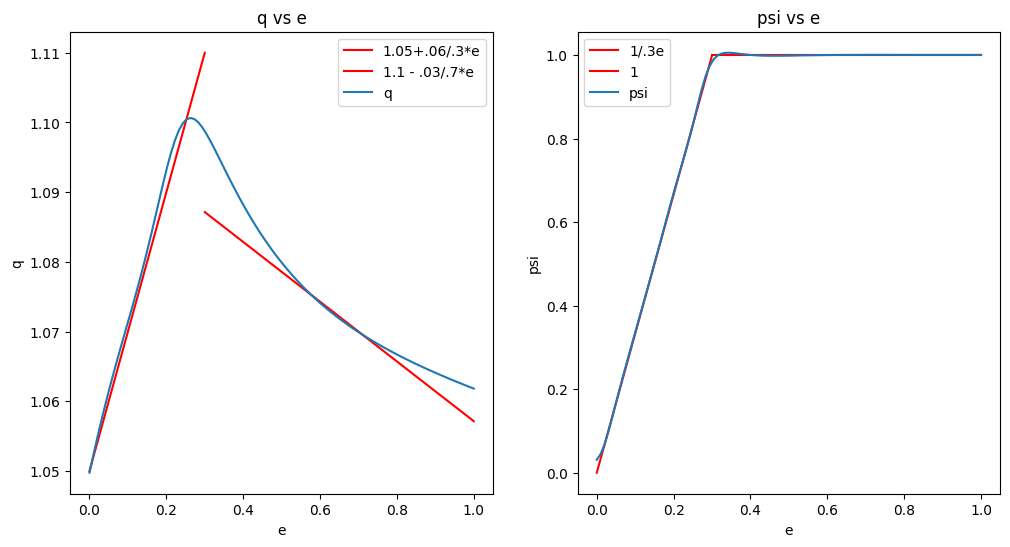

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
e = np.linspace(0, 1)
e1 = np.linspace(0, 0.3)
e2 = np.linspace(0.3, 1)
ax[0].plot(e1, 1.05+0.06/0.3*e1, label="1.05+.06/.3*e", color="red")
ax[0].plot(e2, 1.1 - .03/.7*e2, label="1.1 - .03/.7*e", color="red")
ax[1].plot(e1, 1/.3*e1, label="1/.3e", color="red")
ax[1].plot(e2, np.ones_like(e2), label="1", color="red")
pde_model.endog_vars["q"].plot("q", {"e": [0, 1]}, ax=ax[0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()

## basic training

In [5]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"num_epochs": 100, "loss_log_interval": 10, "optimizer_type": OptimizerType.Adam}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0., 1.0]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "(2*ah*kappa + (kappa*r)**2 + 1)**0.5 - kappa*r", pde_model.variable_val_dict,
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")

sys1 = System([Constraint("psi", Comparator.LT, "1", "non-opt")], label="non-opt", latex_var_mapping=latex_var_mapping)
sys1.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")
sys2 = System([Constraint("psi", Comparator.GEQ, "1", "opt")], label="opt", latex_var_mapping=latex_var_mapping)
sys2.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = a - \iota$")

pde_model.add_system(sys1)
pde_model.add_system(sys2)

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility/model.pt"):
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_init_best.pt"))
    pde_model.train_model("./models/BruSan14_log_utility", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_best.pt"))
    pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 100,
 "lr": 0.001,
 "loss_log_interval": 10,
 "optimizer_type": "Adam"
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions====================

Total loss: 0.0179: 100%|██████████| 100/100 [00:01<00:00, 75.85it/s]

training finished, total time :: 1.3249192237854004
Best model saved to ./models/BruSan14_log_utility/model_best.pt if valid
Model saved to ./models/BruSan14_log_utility/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0001,
constraint_1: 0.0000,
endogeq_1: 0.0010,
system_non-opt: 0.0002,
system_opt: nan,
total_loss: 0.0013


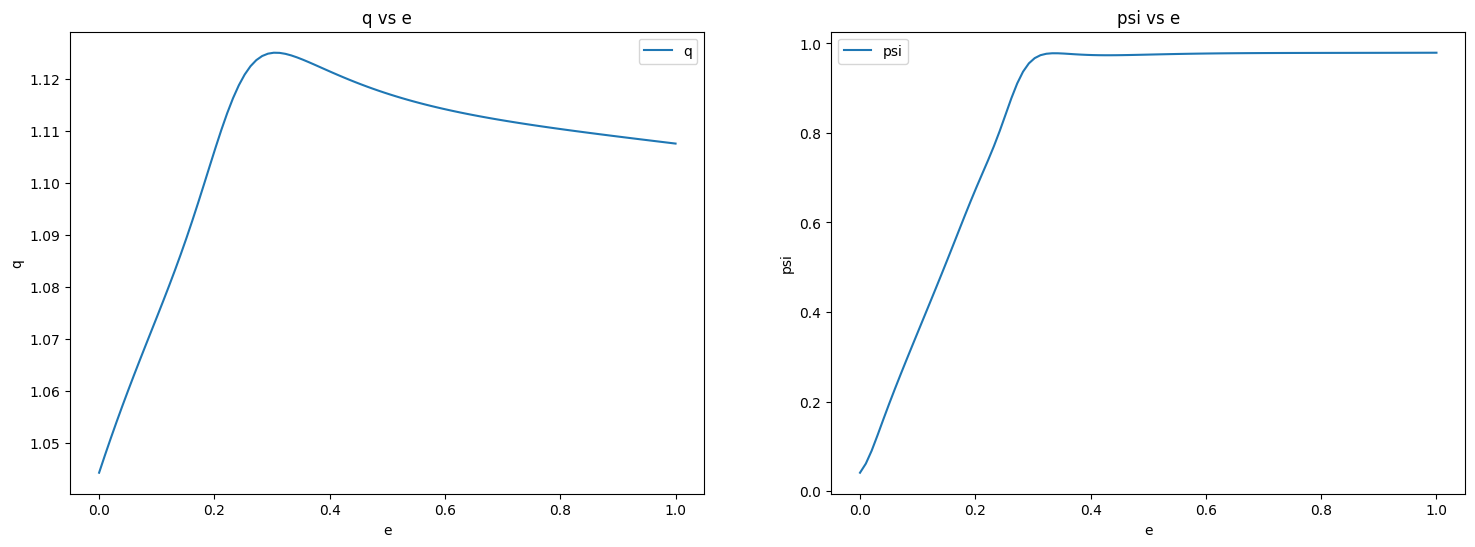

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
e = np.linspace(0, 1)
pde_model.endog_vars["q"].plot("q", {"e": [0, 1]}, ax=ax[0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()

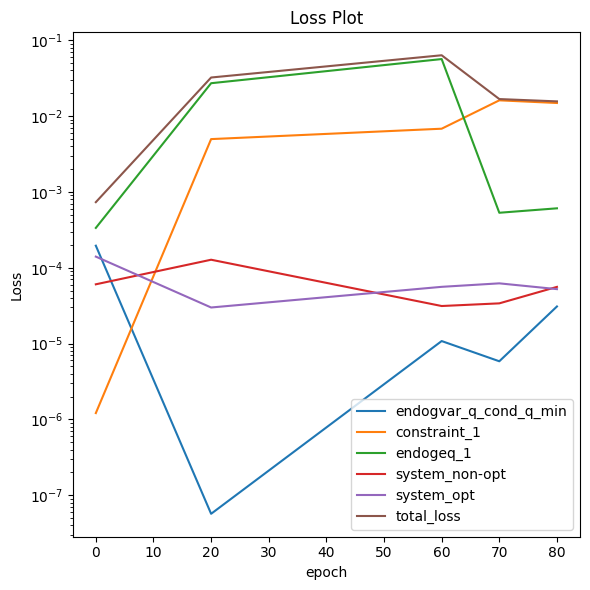

In [7]:
plot_loss_df(fn="./models/BruSan14_log_utility/model_loss.csv", loss_plot_fn="./models/BruSan14_log_utility/model_loss.jpg")

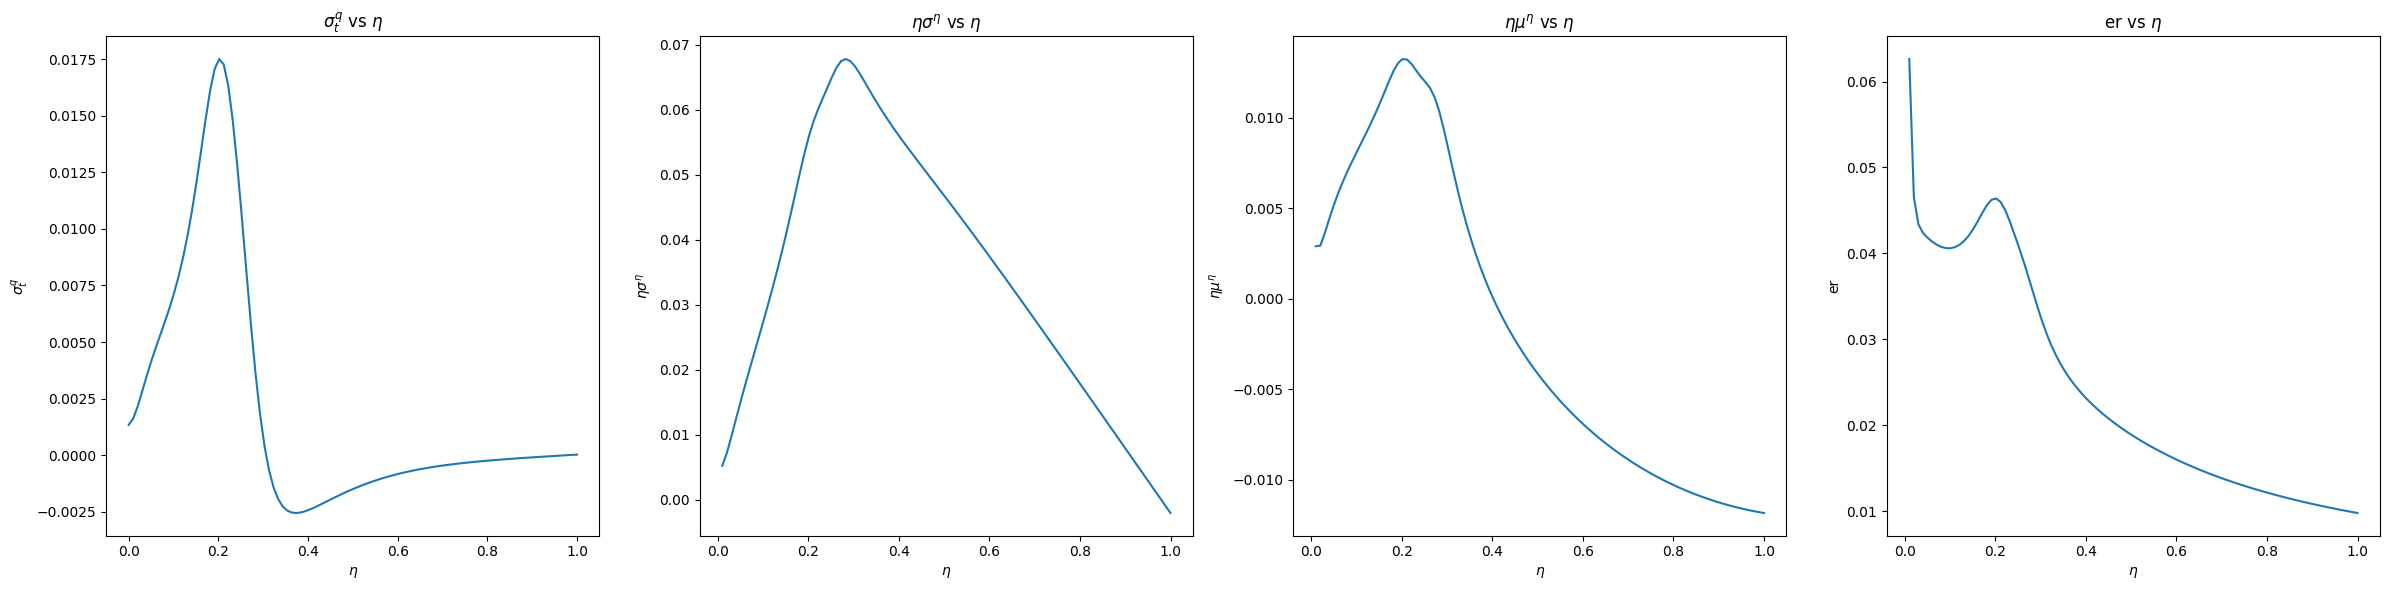

In [8]:
pde_model.plot_vars([r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"])

## active learning

In [14]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"num_epochs": 100, "loss_log_interval": 10, "optimizer_type": OptimizerType.Adam}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0., 1.0]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "(2*ah*kappa + (kappa*r)**2 + 1)**0.5 - kappa*r", pde_model.variable_val_dict,
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")

sys1 = System([Constraint("psi", Comparator.LT, "1", "non-opt")], label="non-opt", latex_var_mapping=latex_var_mapping)
sys1.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")
sys2 = System([Constraint("psi", Comparator.GEQ, "1", "opt")], label="opt", latex_var_mapping=latex_var_mapping)
sys2.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = a - \iota$")

pde_model.add_system(sys1)
pde_model.add_system(sys2)

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility/model_active.pt"):
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_init_best.pt"))
    pde_model.train_model_active_learning([[0.2, 0.4], [0.6, 0.8]], "./models/BruSan14_log_utility", "model_active.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_active_best.pt"))
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_active_best.pt"))
    pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 100,
 "lr": 0.001,
 "loss_log_interval": 10,
 "optimizer_type": "Adam"
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions====================

Total loss: 0.0103: 100%|██████████| 100/100 [00:02<00:00, 45.46it/s]

training finished, total time :: 2.231699228286743
Best model saved to ./models/BruSan14_log_utility/model_active_best.pt if valid
Model saved to ./models/BruSan14_log_utility/model_active.pt
Model loaded


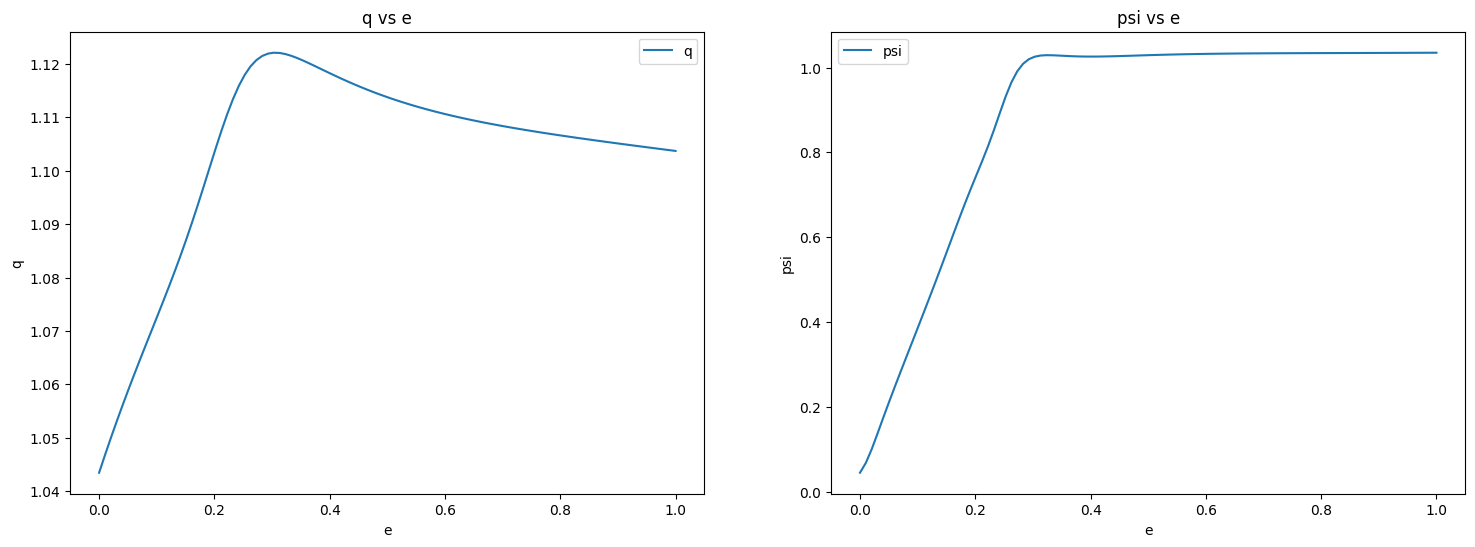

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
e = np.linspace(0, 1)
pde_model.endog_vars["q"].plot("q", {"e": [0, 1]}, ax=ax[0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()

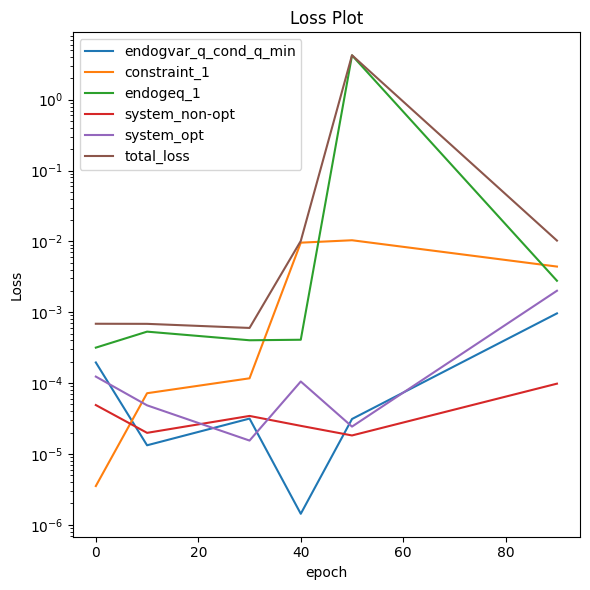

In [16]:
plot_loss_df(fn="./models/BruSan14_log_utility/model_active_loss.csv", loss_plot_fn="./models/BruSan14_log_utility/model_active_loss.jpg")

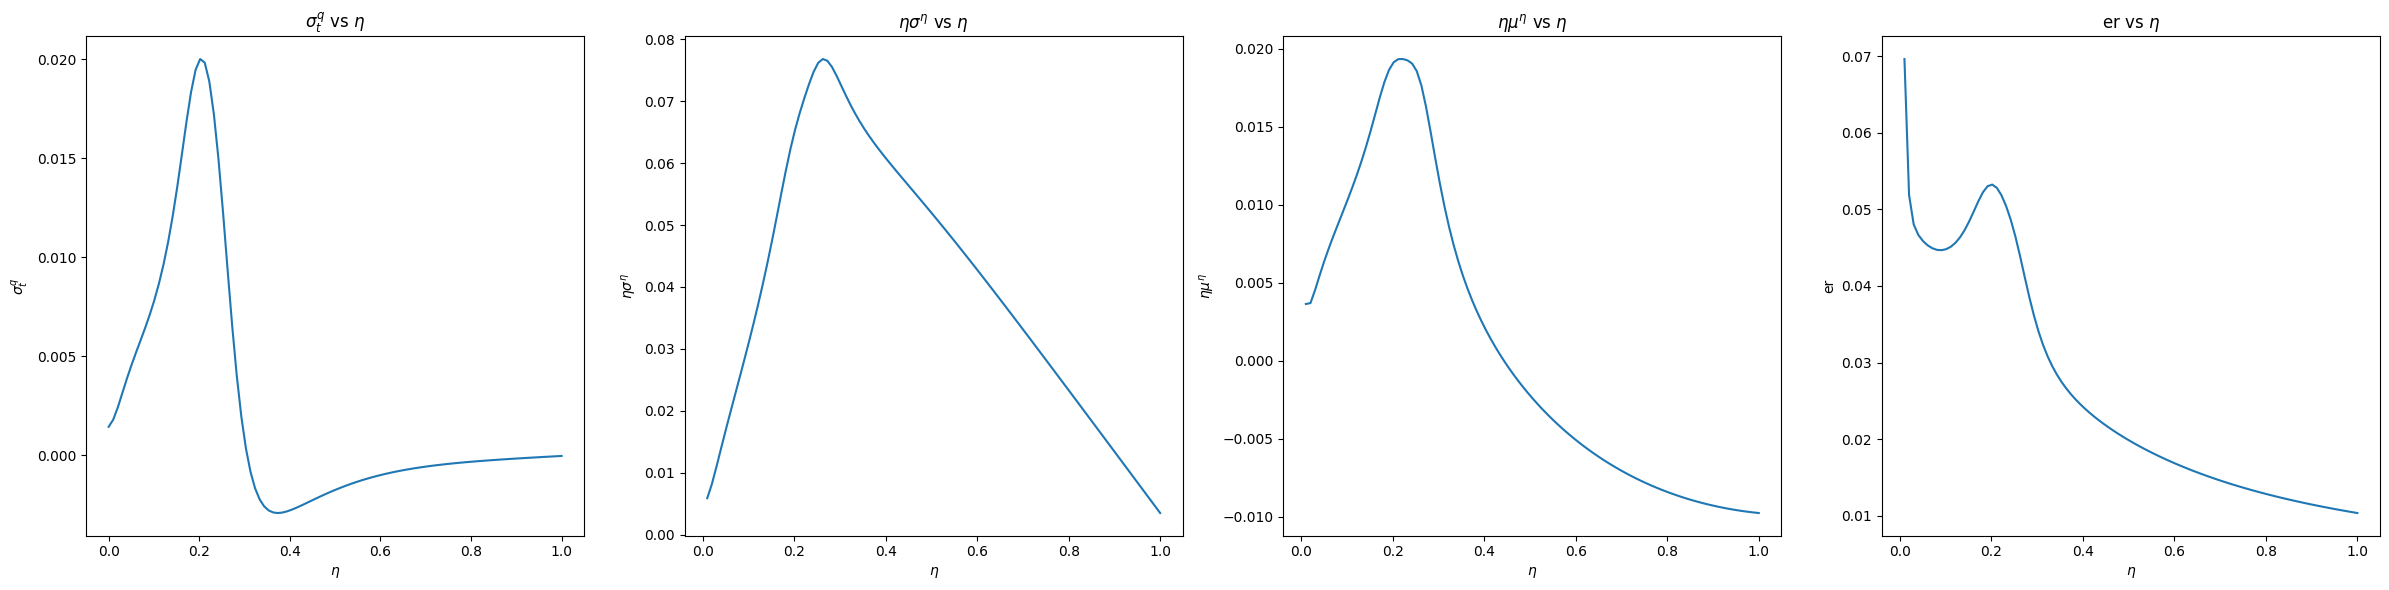

In [17]:
pde_model.plot_vars([r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"])